In [2]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import scipy.misc as smi
from PIL import Image
import sys

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
from IPython.display import Image, display
%matplotlib inline
from IPython.display import clear_output

import sys
sys.path.append('../')
# d-script imports
import data_iters
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.archive.iam_iterator import IAM_MiniBatcher
from data_iters.minibatcher import MiniBatcher
from viz_tools.array_to_png import get_png_from_array, display_img_array
from denoiser.noisenet import conv4p56_model, conv4p120_model, conv3p_model, conv2p_model, conv2_model

# from demo_pipeline.fielutil import *
# from fielutil import *

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)


In [10]:
shingle_dim = (120,120)
write2file = False
overlap=20

hdf5ims = h5py.File('/fileserver/nmec-handwriting/nmec_scaled_flat.hdf5','r')
acoh = 'nmec_author_clean120_overlap20_th80.hdf5'
fcoh = 'nmec_flat_clean120_overlap20_th80.hdf5'

In [9]:
def create_input_buffer( im, input_shape=(None,1,56,56), topbot_overlap = 0 ):
    input_buffer = []
    for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2] - topbot_overlap*2 ):
        for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3] - topbot_overlap*2 ):
            input_buffer += [im[i:i+input_shape[2], j:j+input_shape[3]]]
    return input_buffer

def create_output_im( output_buffer, im, input_shape=(None,1,56,56), topbot_overlap = 0 ):
 
    output_im = np.zeros(im.shape)
    shapesize = (input_shape[2], input_shape[3])
    
    k=0
    # Rearrange the output to form an image
    for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2] - topbot_overlap*2):
        for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3]-topbot_overlap*2):
            output_im[i:i+input_shape[2],j:j+input_shape[3]] = output_buffer[k].reshape(shapesize)
            k+=1
            
    return output_im

In [5]:
if shingle_dim[0]==56:
    print "Loading original weights into GPU memory"
    model=conv4p56_model(shingle_dim=(56,56))
    model.load_weights('/fileserver/iam/iam-processed/models/noisemodels/conv4p_linet56-iambin-tifs.hdf5')
    print "Finished weight load"
else:
    print "Loading original weights into GPU memory"
    model=conv4p120_model(shingle_dim=(120,120))
    model.load_weights('/fileserver/iam/iam-processed/models/noisemodels/conv4p_linet120-iambin-tifs.hdf5')
    print "Finished weight load"
input_shape = model.input_shape

Loading original weights into GPU memory
Compiling model
Finished compilation
Finished weight load


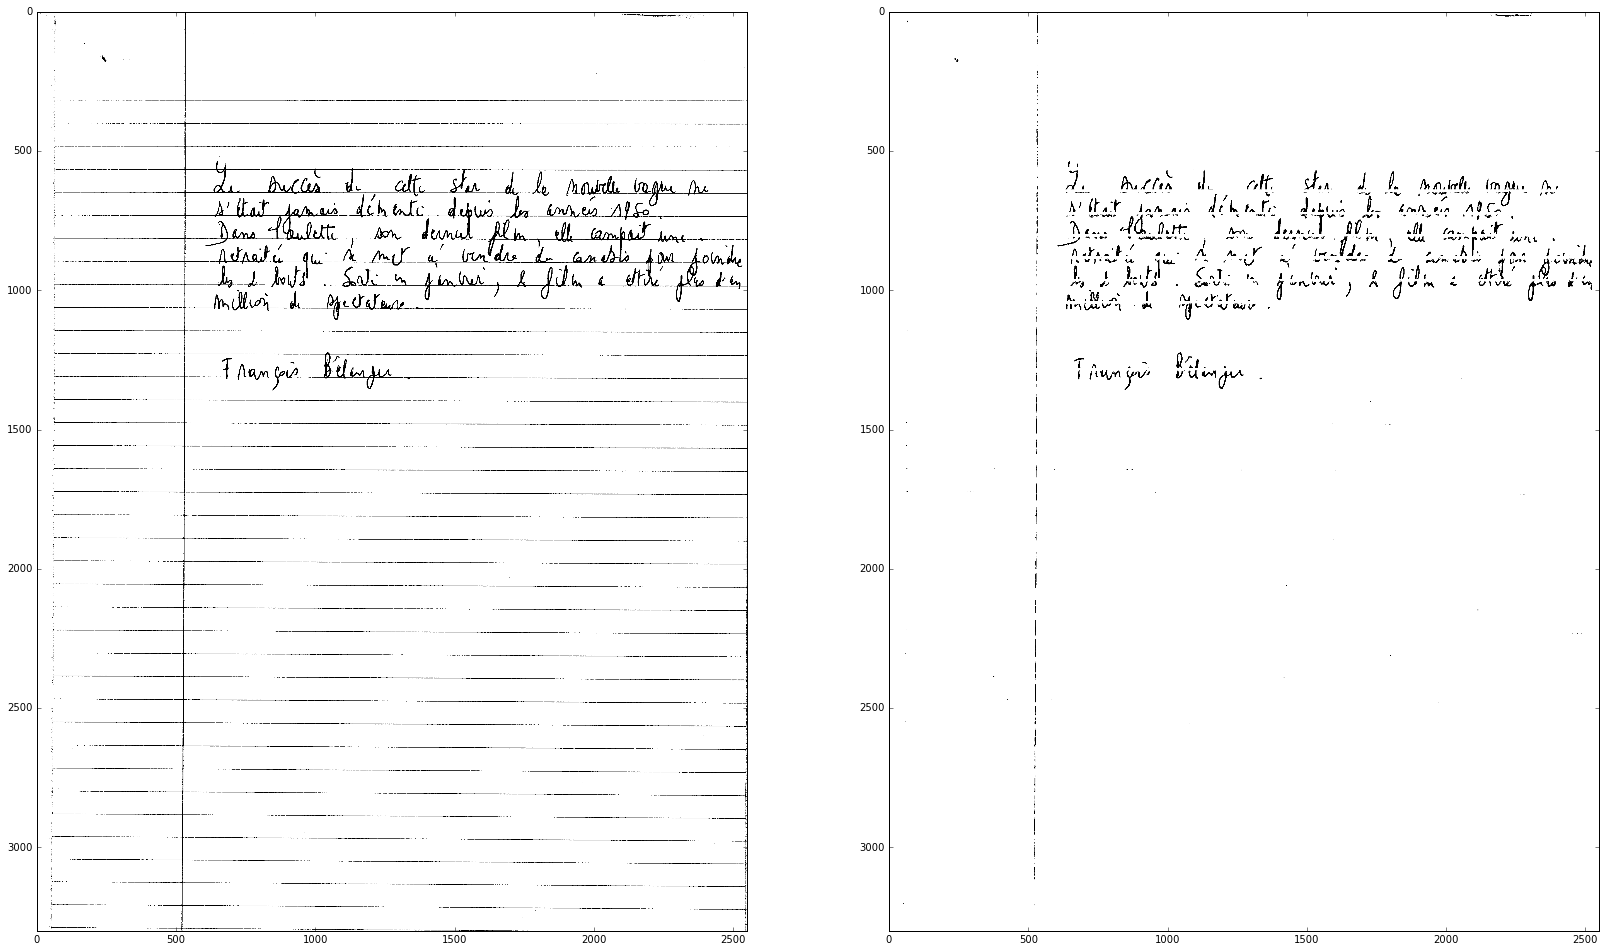

In [12]:
if write2file:
    a_out = h5py.File(acoh,'w')
    f_out = h5py.File(fcoh,'w')
    author_groups = {}

imhdf5 = hdf5ims.keys()[6]
if True:
# for imhdf5 in hdf5ims.keys():
    
    # images referenced in original file
    im = hdf5ims[imhdf5].value
    immin = im.min()
    immax = im.max()
    imthresh = 0.80*(immax - immin)+immin
    im = im < imthresh
    im = (1-im)*255

    # label in the HDF5 file
    the_author = imhdf5.split('-')[1]
    print "Working on "+imhdf5+" author "+the_author
    
    # Cleanse the image
    # Build the input buffer
    input_buffer = create_input_buffer(im, input_shape=input_shape, topbot_overlap = overlap)
    
    # Use NN to predict the image
    predictbuffer = np.expand_dims(1.0-np.array(input_buffer)/255.0, 1)
    output_buffer = model.predict(predictbuffer, verbose = 1)
    
    # Reshape the image to conform to original image size
    output_im = create_output_im( output_buffer, im, input_shape=input_shape, topbot_overlap = overlap )
    
    # Threshold black white
    output_im = output_im > 0.5
    
    # This part is dumb. We're going to invert and change it.
    output_im = (1-output_im)*255
    
    clear_output()
    plt.figure()
    plt.subplots(1,2,figsize=(14,14))
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(output_im, cmap='gray')
    
    # Write image to HDF5 file
    if write2file:
        if not author_groups.has_key(the_author):
            author_groups[the_author] = a_out.create_group(the_author)
        author_groups[the_author].create_dataset( imhdf5, data=output_im.astype(np.uint8) )
        data_group = f_out.create_dataset( imhdf5, data=output_im.astype(np.uint8) )

if write2file:
    a_out.close()
    f_out.close()

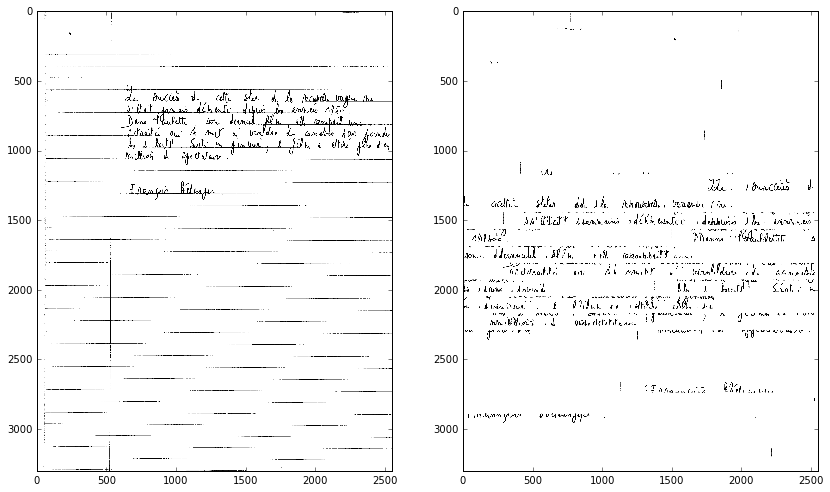

In [7]:
clear_output()
plt.figure()
plt.subplots(1,2,figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(output_im, cmap='gray')